# Acknowledgements

I would like to express my sincere gratitude to my supervisor, Stefan Nielsen (github: stefanazzz), for their guidance and support throughout this project. Their instruction in writing the code and the provision of sample scripts at the beginning were invaluable in helping me to develop and structure my work.

In [120]:
# Install libraries and packages
%pip install obspy
%pip install soundfile
%pip install librosa
%pip install ipywidgets
%matplotlib ipympl
import obspy
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import read
from obspy import read, UTCDateTime
from obspy.taup import TauPyModel
from obspy.taup import plot_travel_times

import scipy.signal
from scipy.fft import fftshift
from scipy.io import wavfile

import soundfile as sf
import librosa.display

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Part 1: Audification Process

In [24]:
# Step 0: Download data from IRIS and save to MSEED files

# === PARAMETERS TO SET ===
network = "IU"          # e.g., "IU", "II", "IC"
station = "HNR"        # e.g., "ANMO" 
location = "*"          # can be "" or "*" for wildcard
channel = "BH?"         # "BH?" selects BHE(East–West horizontal component), BHN (North–South), BHZ(vertical) 
start_time = UTCDateTime("2007-04-01T20:05:00")  
end_time = UTCDateTime("2007-04-01T21:40:00")

# Set the file folder name
desktop_path = os.path.expanduser("~/Desktop/research project/test_folder") # save the data into the required folder

# Set the file path
os.makedirs(desktop_path, exist_ok=True)
output_filename = os.path.join(desktop_path, f"{station}_{start_time.date}_.mseed")

In [26]:
# === DOWNLOAD DATA ===
client = Client("IRIS")

print(f"Requesting data from {network}.{station} between {start_time} and {end_time}...")
st = client.get_waveforms(network=network, station=station, location=location,
                          channel=channel, starttime=start_time, endtime=end_time)

# === SAVE TO FILE ===
print(f"Saving data to {output_filename}...")
st.write(output_filename, format="MSEED")
print("✅ Saved.")

Requesting data from IU.HNR between 2007-04-01T20:05:00.000000Z and 2007-04-01T21:40:00.000000Z...
Saving data to /Users/ruby/Desktop/research project/test_folder/HNR_2007-04-01_.mseed...
✅ Saved.


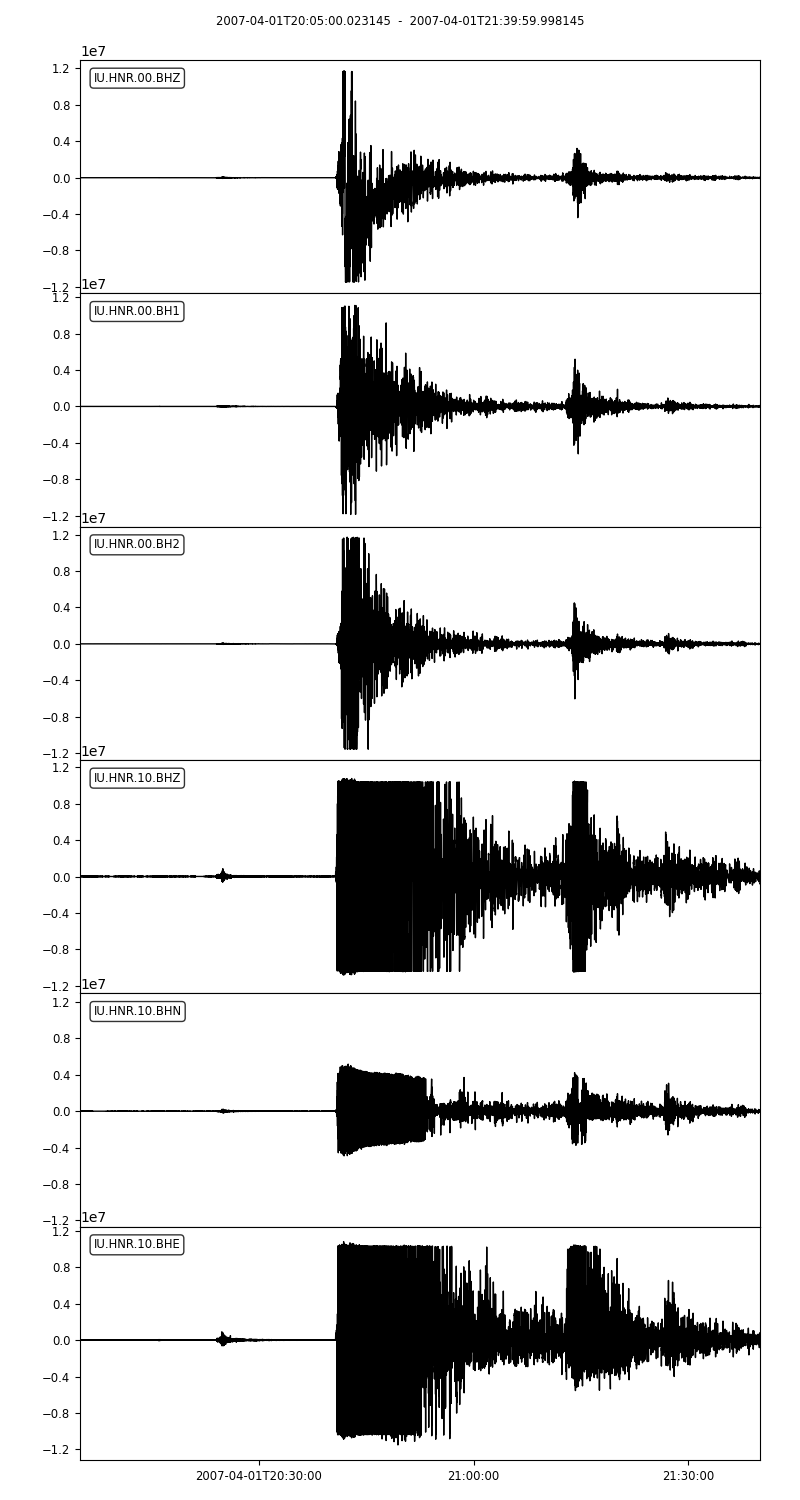

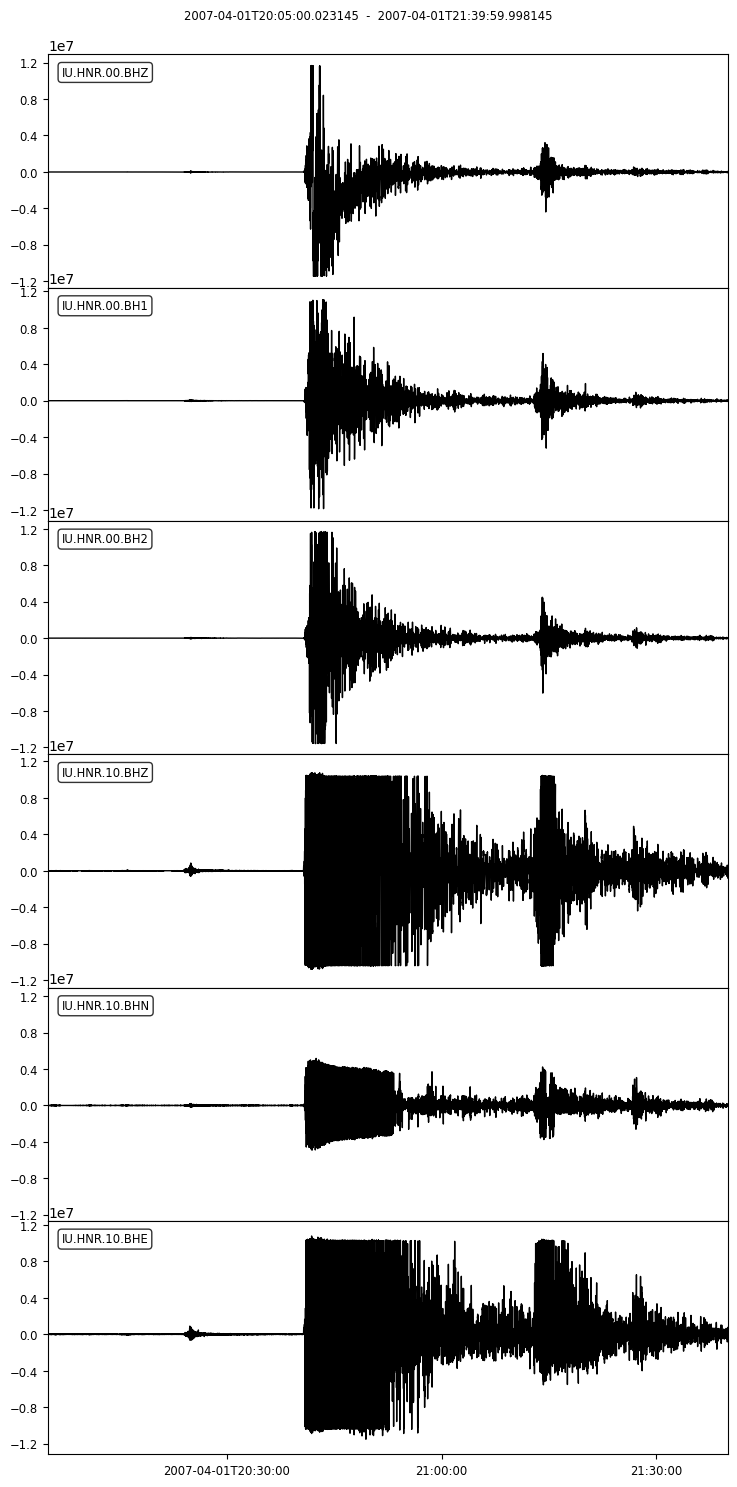

In [122]:
# Step 1: Plot the miniseed file to check the waveforms
st = read(output_filename)
st.plot()

In [30]:
# Step 1: Print out all the results in a stream object to check (optional)
print(st) # select the required component

6 Trace(s) in Stream:
IU.HNR.00.BH1 | 2007-04-01T20:05:00.035645Z - 2007-04-01T21:39:59.985645Z | 20.0 Hz, 114000 samples
IU.HNR.00.BH2 | 2007-04-01T20:05:00.035645Z - 2007-04-01T21:39:59.985645Z | 20.0 Hz, 114000 samples
IU.HNR.00.BHZ | 2007-04-01T20:05:00.035645Z - 2007-04-01T21:39:59.985645Z | 20.0 Hz, 114000 samples
IU.HNR.10.BHE | 2007-04-01T20:05:00.023145Z - 2007-04-01T21:39:59.998145Z | 40.0 Hz, 228000 samples
IU.HNR.10.BHN | 2007-04-01T20:05:00.023145Z - 2007-04-01T21:39:59.998145Z | 40.0 Hz, 228000 samples
IU.HNR.10.BHZ | 2007-04-01T20:05:00.023145Z - 2007-04-01T21:39:59.998145Z | 40.0 Hz, 228000 samples


In [32]:
# Step 2: Preprocess
tr = st[2] # Take the third component-adjust as necessary trace from the stream object.
tr.detrend("demean") # Removes the average value (mean) from the signal,centering the waveform around zero.
tr.filter("bandpass", freqmin=0.1, freqmax=9.50)  # Remove noise outside the designed range, adjust as needed.

# reference: https://docs.obspy.org/packages/obspy.signal.html


IU.HNR.00.BHZ | 2007-04-01T20:05:00.035645Z - 2007-04-01T21:39:59.985645Z | 20.0 Hz, 114000 samples

In [34]:
# Step 3: Extract data and compress time
signal = tr.data.astype(np.float32) # Converts the trace data from its native format (often int32) to 32-bit float, which is standard for signal processing.
# reference: https://numpy.org/devdocs/reference/generated/numpy.ndarray.astype.html
fs_original = tr.stats.sampling_rate # usually 40 Hz or 20 Hz
compression_factor = 20 # adjust as needed

# Compress the First time by 20.
signal_compressed = scipy.signal.resample(signal, int(len(signal) / compression_factor)) # time compression by resampling the signal to reduce its length
# reduce the number of elemments in "signal" to the required number of elements: int(len(signal) / compression_factor)
# references: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

# Compress the Second time by 20. (later by using sf.write)
fs_new = int(fs_original * compression_factor) # Computes the new sampling rate that matches the compressed signal.


In [36]:
# Step 4: Normalize
signal_compressed /= np.max(np.abs(signal_compressed)) #normalizes the signal to the range [-1, 1]

# np.abs(): Calculate the absolute value element-wise.
# references: https://numpy.org/doc/2.0/reference/generated/numpy.absolute.html

# np.max(): gets the maximum absolute value in the signal.
# references: https://numpy.org/doc/2.2/reference/generated/numpy.max.html

# x /= n equivalent to: x = x / n

In [38]:
# Step 5: Save as .wav audio file
sf.write("/Users/ruby/Desktop/research project/test_IU_HNR_2005_2140.wav", signal_compressed, fs_new)
# signal_compressed : audio data array ~[-1,1]
# fs_new : 40 Hz * 20 (compression factor) = 800 (samples/second) -> Compress the Second time by 20.
# the audio has been compressed "400" times quicker.

print("✅ Saved.")

# references: https://docs.python.org/3/library/wave.html
# references: https://python-soundfile.readthedocs.io/en/0.13.1/

✅ Saved.


# Part 2: Calculate the phase arrival times

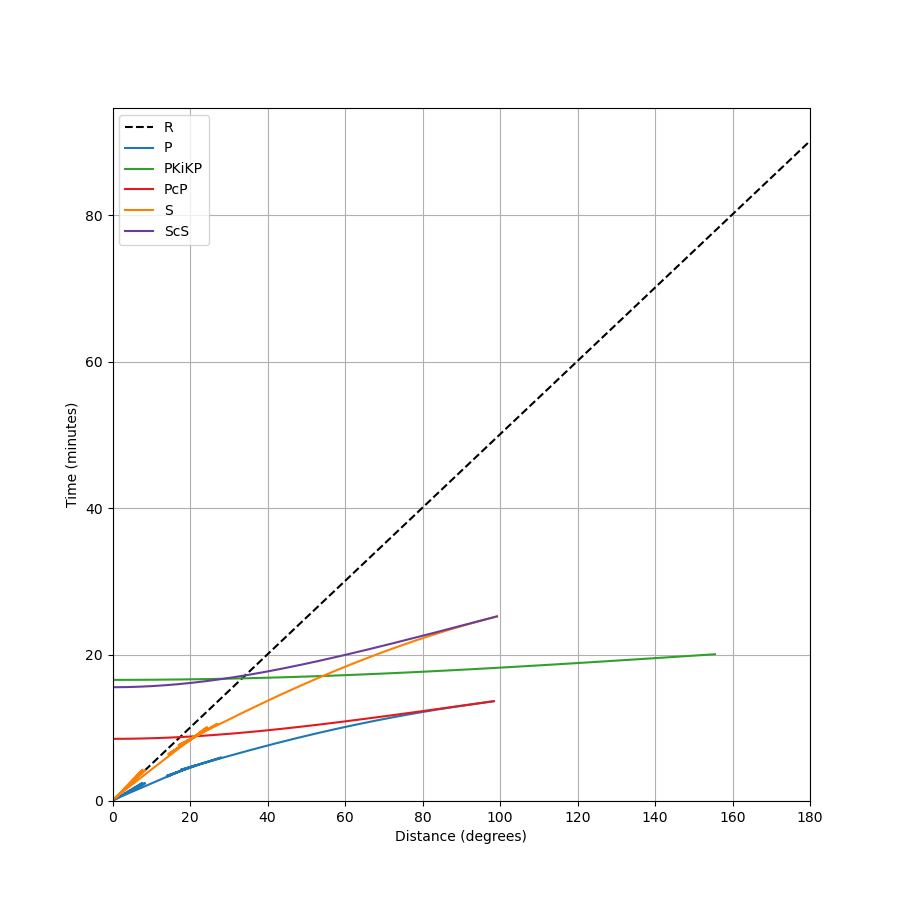

In [20]:
"""
Plot arrival times as a funciont of epicentral distance
@author: Professor Stefan Nielsen (github: stefanazzz)
"""
model = TauPyModel(model="iasp91")

phases = ["P", "S", "P", "PcP","ScS", "PKiKP"]
max_del = 100
max_tim = 100
V_Ral = 3.7
#%%
fig, ax = plt.subplots(figsize=(9, 9))
tr=[]
dels = np.linspace(0, 180, num=180)
for i, val in enumerate(dels):
    tr.append(val*111.2/(60*V_Ral))
ax.plot(dels,tr,'k--', label='R')    
#%%
plot_travel_times(source_depth=10, 
                 phase_list=phases, ax=ax, fig=fig)
ax.set_xlim(0,max_del)
ax.set_ylim(0,max_tim)

# Add vertical line(s) representing the epicentral distance (degree)
ax.plot(dels, tr, 'k--', label='R')  # Existing plot
ax.axvline(x=40.01, color='blue', linestyle='--', linewidth=1.5)  # epicentral distance and color can be adjusted as necessary


In [22]:
# calculate the body wave arrival times

# Initialise model
model = TauPyModel(model="iasp91")

# Station distances in degrees, modify as necessary
stations = {
    "IC.ENH": 3.05,
    "IC.HIA": 21.99,
    "II.ARU": 40.01,
    "IU.NWAO": 65.32,
    "IU.CASY": 97.5    
}

# Phases to extract
phases_to_check = ["P", "S", "PKiKP", "ScS", "PcP"]

# Collect arrival times
arrival_results = []
for station, distance in stations.items():
    arrivals = model.get_travel_times(source_depth_in_km=30,
                                      distance_in_degree=distance,
                                      phase_list=phases_to_check)
    arrival_times = {phase: None for phase in phases_to_check}
    for a in arrivals:
        if a.name in arrival_times and arrival_times[a.name] is None:
            arrival_times[a.name] = a.time

    s_p_time = (arrival_times["S"] - arrival_times["P"]
                if arrival_times["P"] is not None and arrival_times["S"] is not None else None)

    arrival_results.append({
        "Station": station,
        "Distance (°)": distance,
        "P Arrival (s)": arrival_times["P"],
        "S Arrival (s)": arrival_times["S"],
        "S–P Time (s)": s_p_time,
        "PKiKP Arrival (s)": arrival_times["PKiKP"],
        "ScS Arrival (s)": arrival_times["ScS"],
        "PcP Arrival (s)": arrival_times["PcP"],
        
    })

# Convert to DataFrame and print
df_arrivals = pd.DataFrame(arrival_results)
print(df_arrivals.to_string(index=False))

Station  Distance (°)  P Arrival (s)  S Arrival (s)  S–P Time (s)  PKiKP Arrival (s)  ScS Arrival (s)  PcP Arrival (s)
 IC.ENH          3.05      46.159143      82.297622     36.138479         989.685469       927.770245       506.728374
 IC.HIA         21.99     291.535645     533.480075    241.944430         994.963951       968.609172       528.865898
 II.ARU         40.01     451.926513     816.322197    364.395684        1007.173461      1056.476000       576.408218
IU.NWAO         65.32     639.170607    1161.642908    522.472302        1035.086992      1232.048580       671.002725
IU.CASY         97.50     810.797181    1493.260095    682.462914        1085.374488      1493.384148       810.808978


# Part 3: Read the miniseed file and create spectrogram and waveform

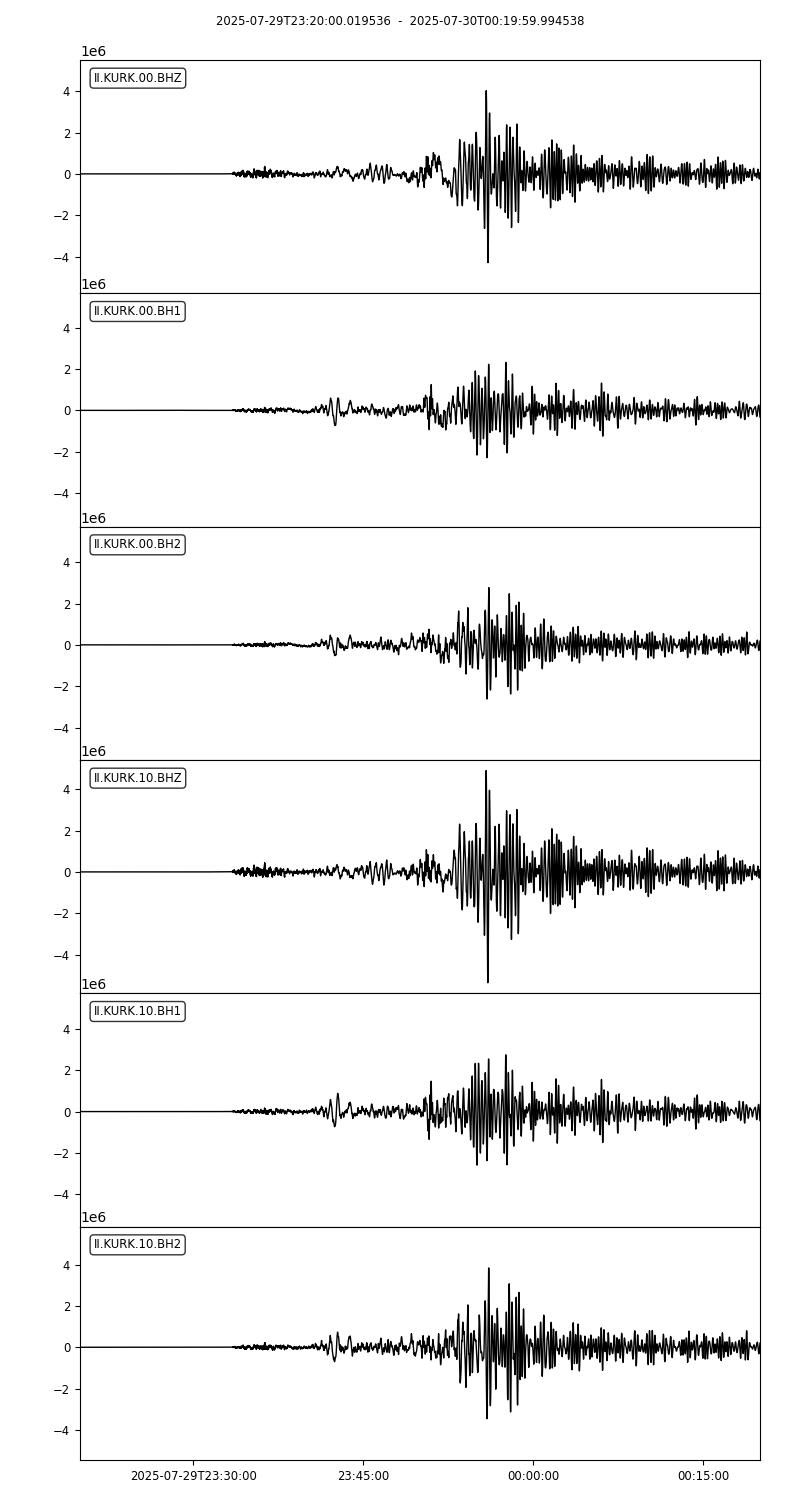

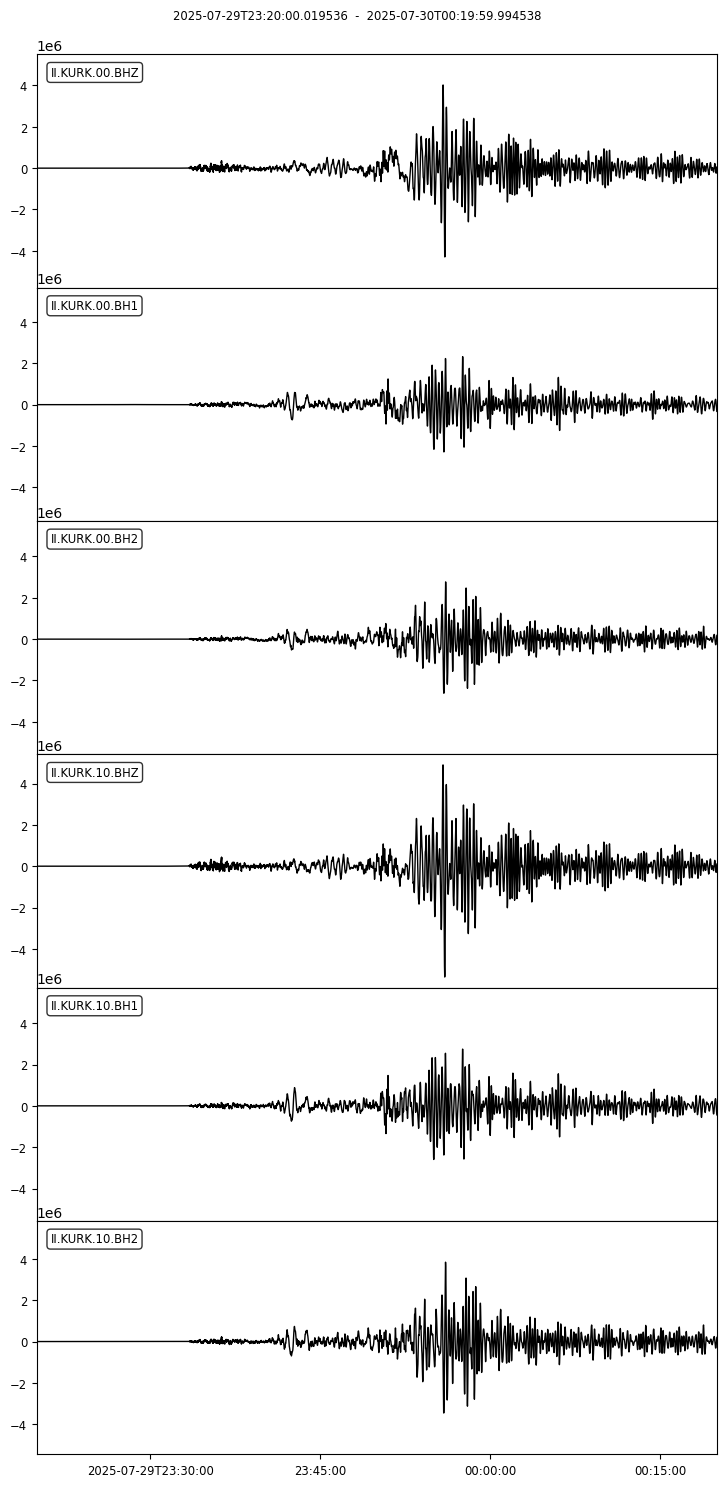

In [40]:
# Step 1: Load the miniSEED file and plot

file_path = os.path.expanduser("~/Desktop/research project/update_raw data_Kamchatka8.8/KURK_2025-07-29_2320_0020.mseed")
st = read(file_path)
st.plot()


In [42]:
# Step 2: Preprocessing (similar to part 1)
tr = st[2]
tr.detrend("demean")
tr.filter("bandpass", freqmin=0.1, freqmax=9.5)

# Step 3: Compress signal
signal = tr.data.astype(np.float32)
fs_original = tr.stats.sampling_rate
compression_factor = 20
signal_compressed = scipy.signal.resample(signal, int(len(signal) / compression_factor)) 
fs_new = int(fs_original * compression_factor)

# Step 4: normalize
signal_compressed /= np.max(np.abs(signal_compressed)) 

# Step 5: time arrays
compressed_duration = len(signal_compressed) / fs_new
compressed_time = np.linspace(0, compressed_duration,len(signal_compressed))

In [44]:
# Step 6: Calculate the phase arrival time in the mseed file

# ObsPy mseed start and end time
trace_start_time = tr.stats.starttime
trace_end_time = tr.stats.endtime
print("Trace starts at:", trace_start_time)
print("Trace ends at:", trace_end_time)

# The origin time of the earthquake
origin_time = UTCDateTime("2025-07-29T23:24:52") # input the original earthquake origin time (UTC）
print("Earthquake starts at:", origin_time)

Trace starts at: 2025-07-29T23:20:00.019536Z
Trace ends at: 2025-07-30T00:19:59.994536Z
Earthquake starts at: 2025-07-29T23:24:52.000000Z


In [48]:
# Step 6: Calculate the phase arrival time in the mseed file

# Body wave arrival times relative to origin (in seconds)
arrival_after_origin = {
    "P": (515.62),
    "S": (931.96),
    "PKiKP": (1014.65),
    "ScS": (1106.51),
    "PcP": (603.42),
    "R":(1434)
}  # input the calculated phase arrival time in seconds from part 2

In [50]:
# Step 6: Calculate the phase arrival time in the mseed file

# Convert relative seconds after origin to absolute UTCDateTime
arrival_times_utc = {k: origin_time + v for k, v in arrival_after_origin.items()}

# Offset relative to start of trace (in seconds)
arrival_relative_to_trace = {
    k: float(v - trace_start_time) for k, v in arrival_times_utc.items()
}

# Convert to compressed time domain
arrival_offsets_compressed = {
    k: v /(compression_factor*compression_factor) for k, v in arrival_relative_to_trace.items() if v >= 0
}


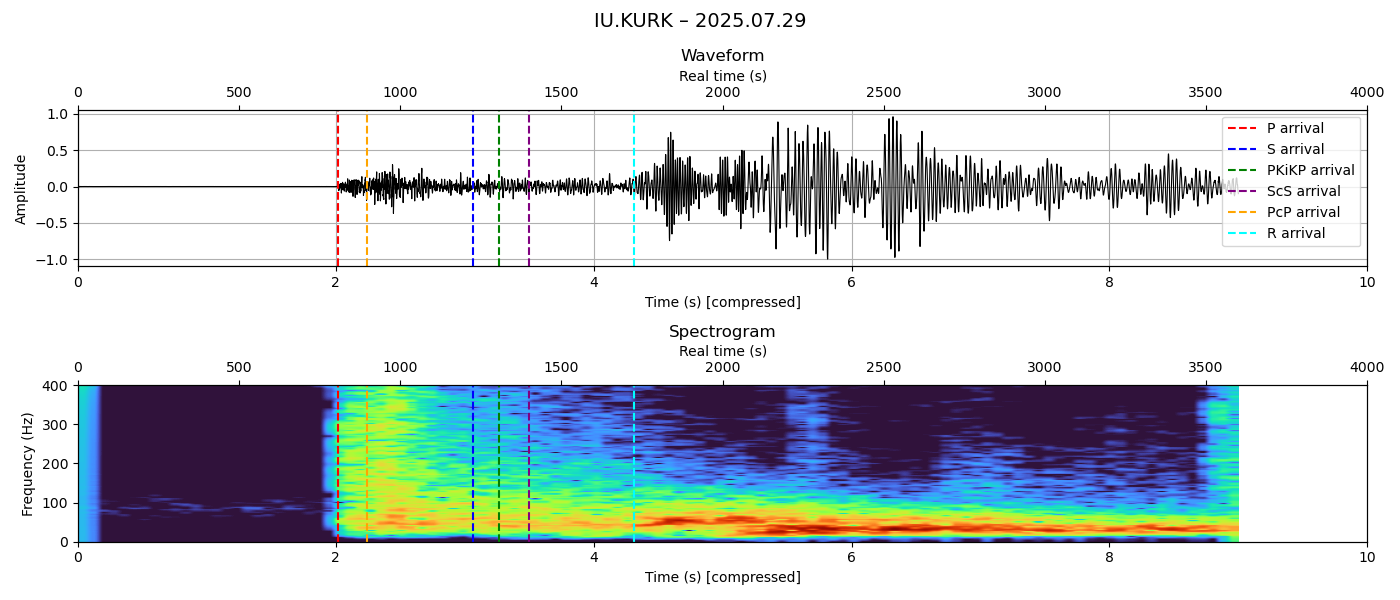

In [52]:
# Step 7: Draw the spectrogram and waveform

# === Spectrogram ===
S = librosa.stft(signal_compressed, n_fft=256)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
spectro_time = np.linspace(0, compressed_duration, S_db.shape[1])

# === Prepare figure and subplots ===
fig, axs = plt.subplots(2, 1, figsize=(14, 6))

# === Plot 1: Compressed waveform ===
axs[0].plot(compressed_time, signal_compressed, color='black', linewidth=0.8)
axs[0].set_title("Waveform")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlabel("Time (s) [compressed]")
axs[0].grid(True)
axs[0].set_xbound(lower = 0, upper = 10)

# === add the second axis to plot 1
ax0_top = axs[0].twiny()

# Get current compressed x-limits
compressed_xlim = axs[0].get_xlim()

# Multiply back by compression factor to get real time
real_xlim = [x * 400 for x in compressed_xlim]

# Set the limits and label on the top axis
ax0_top.set_xlim(real_xlim)
ax0_top.set_xlabel("Real time (s)")

# === Vertical arrival lines (converted to compressed seconds) ===
colors = ["red", "blue", "green", "purple", "orange", "cyan"]
for (label, x), color in zip(arrival_offsets_compressed.items(), colors):
    axs[0].axvline(x=x, linestyle='--', linewidth=1.5, color=color, label=f"{label} arrival")
    axs[1].axvline(x=x, linestyle='--', linewidth=1.5, color=color)
axs[0].legend(loc="upper right")

# === Plot 2: Spectrogram ===
img = axs[1].imshow(S_db, aspect='auto', origin='lower', 
                    extent=[spectro_time[0], spectro_time[-1], 0, fs_new / 2],
                    cmap='turbo')

axs[1].set_title("Spectrogram")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_xlabel("Time (s) [compressed]")
axs[1].set_xbound(lower = 0, upper = 10)

# === add the second axis to plot 2
ax1_top = axs[1].twiny()
compressed_xlim = axs[1].get_xlim()
real_xlim = [x * 400 for x in compressed_xlim]
ax1_top.set_xlim(real_xlim)
ax1_top.set_xlabel("Real time (s)")

# === Title + show ===
plt.suptitle("IU.KURK – 2025.07.29", fontsize=14) # change the name if needed
plt.tight_layout()
plt.show()

# Part 3: Create animation video

In [74]:
# load the WAV file
audio_path = os.path.expanduser("~/Desktop/research project/1. Audio/2025-07-29Kamchatka8.8_update/II_KURK_2320_0020.wav")
fs_new, signal = wavfile.read(audio_path)

# If 16-bit PCM, convert back to float:
if signal.dtype == np.int16:
    signal = signal.astype(np.float32) / 32767


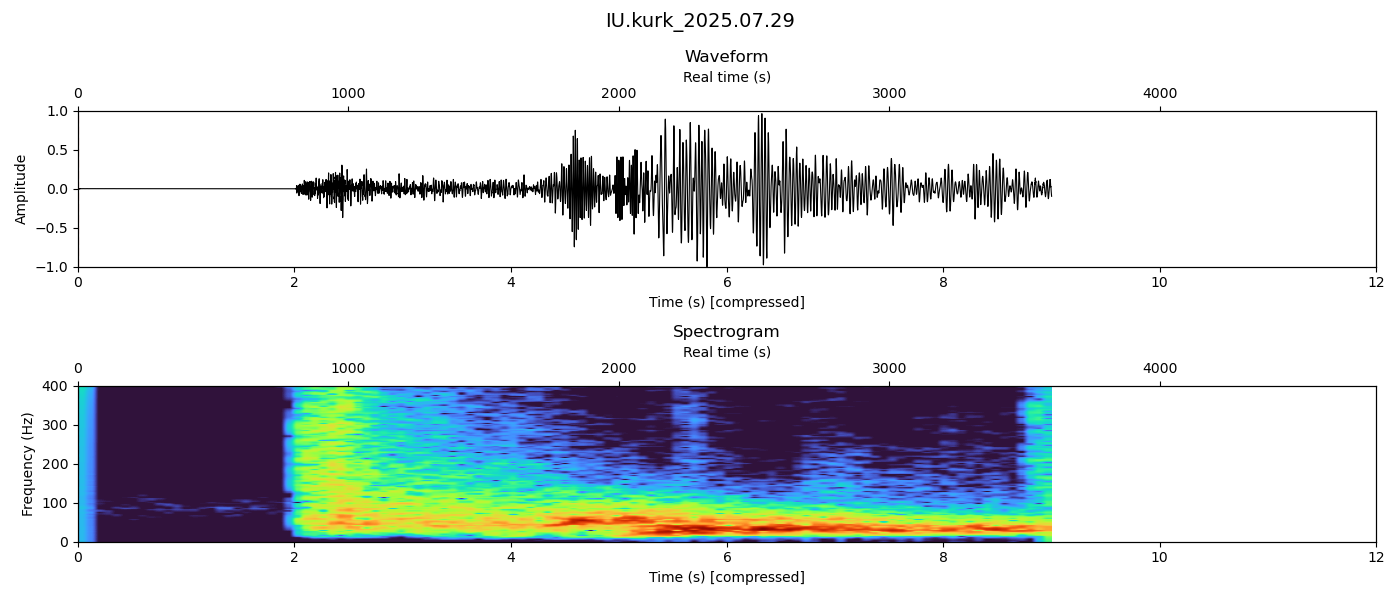

In [110]:
# === Spectrogram (reuse S_db and spectro_time from earlier) ===
S = librosa.stft(signal, n_fft=256)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
spectro_time = np.linspace(0, compressed_duration, S_db.shape[1])

# === Create figure and subplots ===
fig, axs = plt.subplots(2, 1, figsize=(14, 6))

# === Plot 1: Waveform ===
line, = axs[0].plot(compressed_time, signal, color='black', linewidth=0.8)
marker_top = axs[0].axvline(x=0, color='red', linestyle='--') # define marker_top
axs[0].set_title("Waveform")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlabel("Time (s) [compressed]")
axs[0].set_xlim(0, 12)
axs[0].set_ylim(-1, 1)

# === Add real-time top axis to waveform ===
ax0_top = axs[0].twiny()
compressed_xlim = axs[0].get_xlim()
real_xlim = [x * 400 for x in compressed_xlim]
ax0_top.set_xlim(real_xlim)
ax0_top.set_xlabel("Real time (s)")

# === Plot 2: Spectrogram ===
img = axs[1].imshow(S_db, aspect='auto', origin='lower',
                    extent=[spectro_time[0], spectro_time[-1], 0, fs_new / 2],
                    cmap='turbo')
marker_bottom = axs[1].axvline(x=0, color='red', linestyle='--') # define marker_bottom
axs[1].set_title("Spectrogram")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_xlabel("Time (s) [compressed]")
axs[1].set_xlim(0, 12)

# === Add real-time top axis to spectrogram ===
ax1_top = axs[1].twiny()
compressed_xlim = axs[1].get_xlim()
real_xlim = [x * 400 for x in compressed_xlim]

ax1_top.set_xlim(real_xlim)
ax1_top.set_xlabel("Real time (s)")

plt.suptitle("IU.kurk_2025.07.29", fontsize=14)
plt.tight_layout()

In [112]:
# === Animate marker across time ===
frame_rate = 30
step = int(fs_new / frame_rate)
frames = range(0, len(compressed_time), step)

def update(frame_idx):
    t_val = compressed_time[frame_idx]
    marker_top.set_xdata([t_val])
    marker_bottom.set_xdata([t_val])
    return marker_top, marker_bottom

ani = animation.FuncAnimation(
    fig,
    update,
    frames=frames,
    blit=True
)

In [114]:
# check if ffmpeg works (optional)
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
!ffmpeg -version

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
built with Apple clang version 16.0.0 (clang-1600.0.26.6)
configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

In [116]:
# === Save animation (no audio yet) ===
video_no_audio = "IU_KURK_2320_0020_audio.mp4"
writer = animation.FFMpegWriter(fps=frame_rate, bitrate=1800)
ani.save(video_no_audio, writer=writer)
plt.close()


In [118]:
# === Save final video with audio to Desktop ===
output_dir = os.path.expanduser("~/Desktop/research project/3. Animations")
os.makedirs(output_dir, exist_ok=True)  # Create folder if it doesn't exist

audio_path = os.path.expanduser("~/Desktop/research project/1. Audio/2025-07-29Kamchatka8.8_update/II_KURK_2320_0020.wav")
final_output = os.path.join(output_dir, "IU_KURK_0615_0715_audio.mp4")

os.system(f'ffmpeg -y -i "{video_no_audio}" -i "{audio_path}" -c:v copy -c:a aac -shortest "{final_output}"')

print(f"✅ Exported final video with audio: {final_output}")


✅ Exported final video with audio: /Users/ruby/Desktop/research project/3. Animations/IU_KURK_0615_0715_audio.mp4


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

In [ ]:
# === transform the wav file to mp3 file (if required)
input_wav = os.path.expanduser("~/Desktop/research project/1. Audio/2010-02-27Chile8.8_update/II_HOPE_0620_0720.wav")
output_mp3 = os.path.expanduser("~/Desktop/research project/1. Audio/2010-02-27Chile8.8_update/II_HOPE_0620_0720.mp3")

os.system(f'ffmpeg -y -i "{input_wav}" -codec:a libmp3lame -qscale:a 2 "{output_mp3}"')

=== the end of the code ===